<a href="https://colab.research.google.com/github/ParthikB/encryption/blob/master/encryption_digit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')

Running on : GPU


### Grabbing the Data

In [2]:
train = datasets.MNIST('', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

test  = datasets.MNIST('', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

0it [00:00, ?it/s]

9920512it [00:01, 8565410.71it/s]                            


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 129388.77it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw


1654784it [00:00, 2123077.45it/s]                            
0it [00:00, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw


8192it [00:00, 49451.14it/s]            


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw
Processing...
Done!


## Creating the Dataset Tensor

In [0]:
BATCH_SIZE = 32
HEIGHT, WIDTH = 28, 28
TOTAL_PIXELS = HEIGHT*WIDTH

trainSet = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
testSet  = torch.utils.data.DataLoader(test,  batch_size=BATCH_SIZE, shuffle=True)

#### Viewing one Sample

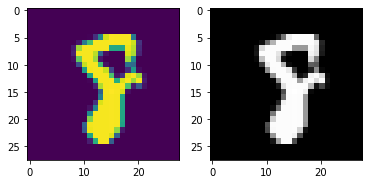

In [5]:
i = 0 # ranging from 0-31
for data in trainSet:
    # data --> one batch containing 32 samples
    x, y = data[0][i], data[1][i]

plt.subplot(1, 2, 1)
plt.imshow(x.view(HEIGHT, WIDTH)) # Reshaping x from (1, Height, Width) --> (Height, Width)

plt.subplot(1, 2, 2)
plt.imshow(x.view(HEIGHT, WIDTH), cmap='gray')

### Checking the Balancing of the Data

Text(0, 0.5, 'Percentage')

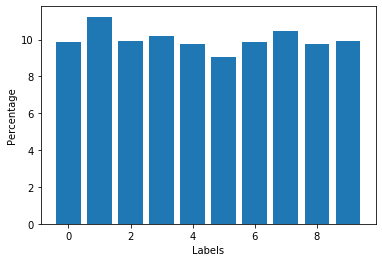

In [0]:
total = 0
counter = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for data in trainSet:
        y = data[1]
        for sample in y:
            counter[int(sample)] += 1
            total += 1
            
for key in counter:
    percentage = round(counter[key]/total * 100, 2)
    counter[key] = percentage

x = [key for key in counter]
y = [counter[key] for key in counter]
plt.bar(x, y)
plt.xlabel('Labels')
plt.ylabel('Percentage')

# The Data is BALANCED

## Creating the Network Structure

In [0]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64,    64)        
        self.fc3 = nn.Linear(64,    64)        
        self.fc4 = nn.Linear(64,    28*28)        
    
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x2 = F.sigmoid(self.fc2(x))        
        x = F.sigmoid(self.fc3(x2))        
        x = F.sigmoid(self.fc4(x))
        
        return x, x2

## Training the Network

  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|          | 7/1875 [00:00<00:26, 69.53it/s]

EPOCH : 1


  1%|          | 21/1875 [00:00<00:08, 209.60it/s]

EPOCH : 2


  1%|          | 21/1875 [00:00<00:08, 207.14it/s]

EPOCH : 3


  1%|          | 20/1875 [00:00<00:09, 187.82it/s]

EPOCH : 4


  1%|          | 21/1875 [00:00<00:09, 202.33it/s]

EPOCH : 5


  1%|          | 22/1875 [00:00<00:08, 214.10it/s]

EPOCH : 6


  1%|          | 23/1875 [00:00<00:08, 224.64it/s]

EPOCH : 7


  1%|          | 20/1875 [00:00<00:09, 199.35it/s]

EPOCH : 8


  1%|          | 22/1875 [00:00<00:08, 215.63it/s]

EPOCH : 9


  1%|          | 22/1875 [00:00<00:08, 219.23it/s]

EPOCH : 10


  1%|          | 22/1875 [00:00<00:08, 215.10it/s]

EPOCH : 11


  1%|          | 22/1875 [00:00<00:08, 209.84it/s]

EPOCH : 12


  1%|          | 21/1875 [00:00<00:09, 205.71it/s]

EPOCH : 13


  1%|          | 20/1875 [00:00<00:09, 197.94it/s]

EPOCH : 14


  1%|          | 21/1875 [00:00<00:09, 205.32it/s]

EPOCH : 15


  1%|          | 22/1875 [00:00<00:08, 212.98it/s]

EPOCH : 16


  1%|          | 20/1875 [00:00<00:09, 193.78it/s]

EPOCH : 17


  1%|          | 21/1875 [00:00<00:08, 206.53it/s]

EPOCH : 18


  1%|          | 21/1875 [00:00<00:08, 208.85it/s]

EPOCH : 19


  1%|          | 18/1875 [00:00<00:10, 175.99it/s]

EPOCH : 20


  1%|          | 21/1875 [00:00<00:08, 208.74it/s]

EPOCH : 21


  1%|          | 21/1875 [00:00<00:08, 207.33it/s]

EPOCH : 22


  1%|          | 21/1875 [00:00<00:08, 208.10it/s]

EPOCH : 23


  1%|          | 21/1875 [00:00<00:08, 206.26it/s]

EPOCH : 24


  1%|          | 22/1875 [00:00<00:08, 210.85it/s]

EPOCH : 25


100%|██████████| 1875/1875 [00:08<00:00, 214.24it/s]


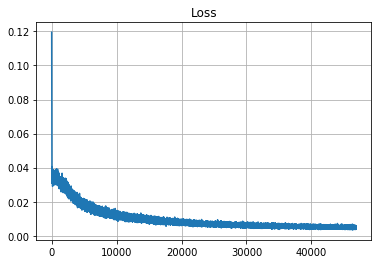

In [9]:
CONTINUE_TRAINING = False
LEARNING_RATE = 0.001 #1e-3
EPOCHS        = 25

if not CONTINUE_TRAINING:
  net = Net().to(device)

  # Define Optimizer
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

  loss_log = []
  
# Iteration Begins
for epoch in range(EPOCHS):
    print('EPOCH :', epoch+1)
    # Iterate over every sample in the batch
    for data in tqdm(trainSet):
        x, _ = data
        net.zero_grad()
        
        #Compute the output
        output, layer2 = net(x.view(-1, TOTAL_PIXELS).to(device))
        
        # Compute Loss
        loss = F.smooth_l1_loss(output, x.view(-1, TOTAL_PIXELS).to(device))
        loss_log.append(loss)
        
        # Backpropagate
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
    # print(loss)
plt.plot(loss_log)
plt.title(f'Loss | Min = {loss_log[-1].item()}')
plt.grid(1)

## Encryption Decryption

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Text(0.5, 1.0, 'Decypted Image')

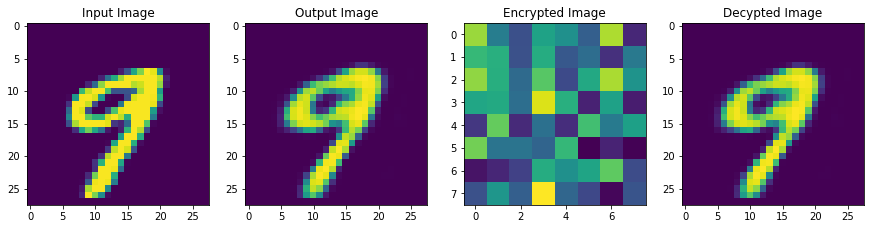

In [18]:
# Selecting a random sample from the dataset
random = np.random.randint(32)

for data in trainSet:
  # print(data)
  sample = data[0][random].view(HEIGHT, WIDTH)
  break


# Passing the sample through the Network and also generating the ENCYPTED IMAGE
with torch.no_grad():
    # for data in trainSet:
        x = sample
        testOutput, encryptedImage = net(x.view(-1, TOTAL_PIXELS).to(device))


# Converting the tensor into numpy array and reshaping from VECTOR to 2D MATRIX
# trainOutput = trainOutput.view(HEIGHT, WIDTH)
# trainOutput = trainOutput.detach().numpy()*255

testOutput  = testOutput.view(HEIGHT, WIDTH)
testOutput  = testOutput.cpu().detach().numpy()*255

encryptedImage  = encryptedImage.view(8, 8)
# encryptedImage  = encryptedImage.cpu().detach().numpy()*255


# DECRYPTING THE IMAGE
with torch.no_grad():
  x = F.sigmoid(net.fc3((torch.tensor(encryptedImage)).view(-1, 64)).to(device))
  # x = F.sigmoid(net.fc3((torch.rand(1, 64))))
  x = F.sigmoid(net.fc4(x))

encryptedImage = encryptedImage.cpu().detach().numpy()*255
decryptedImage = x.view(HEIGHT, WIDTH).cpu().detach().numpy()*255


# PLOTTING THE OUTPUTS
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(sample)
plt.title('Input Image')

plt.subplot(1, 4, 2)
plt.imshow(testOutput)
plt.title('Output Image')

plt.subplot(1, 4, 3)
plt.imshow(encryptedImage)
plt.title('Encrypted Image')

plt.subplot(1, 4, 4)
plt.imshow(decryptedImage)
plt.title('Decypted Image')